### 1. Import libraries

In [2]:
from ezyrb import POD, RBF, Database
from ezyrb import ReducedOrderModel as ROM

from scipy.interpolate import RBFInterpolator
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
np.bool = np.bool_ # to avoid error in pyvista

import matplotlib.pyplot as plt

from varname import nameof
import pyvista as pv

### 2. Read and preprocess of the data

In [3]:
# Assuming your data preparation steps are done here
num_simulations = 200
train_ratio = 0.8

# Load npy data from training_data folder
pressure_data = np.load('training_data/pressure_data_concat.npy')
velocity_data = np.load('training_data/velocity_data_concat.npy')
points_data = np.load('training_data/points_data.npy')

# Load design parameters from training_data folder
design_parameters = np.load('training_data/displacement_data_concat.npy')

In [4]:
random_state = 42

# randomly spit the data into training and testing data
train_pressure, test_pressure = train_test_split(pressure_data, train_size=train_ratio, random_state=random_state)
train_velocity, test_velocity = train_test_split(velocity_data, train_size=train_ratio, random_state=random_state)
train_design_parameters, test_design_parameters = train_test_split(design_parameters, train_size=train_ratio, random_state=random_state)
train_points, test_points = train_test_split(points_data, train_size=train_ratio, random_state=random_state)

In [5]:
# delete columns with all zeros in train_design_parameters
eliminate_columns = np.all(train_design_parameters == 0, axis=0)
train_design_parameters = train_design_parameters[:, ~eliminate_columns]
test_design_parameters = test_design_parameters[:, ~eliminate_columns]

### 3. POD and plot the truncated energy norm

### 4. RBF to interpolate the parameters

In [6]:
# Define a function to evaluate RBF with different parameters
def evaluate_rbf(x,y):
    # List of kernel functions to test
    kernels = ['linear', 'thin_plate_spline', 'cubic', 'quintic', 'multiquadric', 'inverse_multiquadric', 'gaussian']
    epsilons = np.logspace(-3, 3, 7)

    best_kernel = kernels[0]
    best_epsilon = epsilons[0]
    best_score = float('inf')
    
    for kernel in kernels:
        for epsilon in epsilons:
            # print(f'Kernel: {kernel}, Epsilon: {epsilon}')


            # use try to avoid any errors
            try:
                rbf = RBF(kernel=kernel, epsilon=epsilon)
                rbf.fit(x, y)
                y_pred = rbf.predict(x)

                # Evaluate performance
                score = mean_squared_error(y, y_pred)

                # print(f'kernel: {kernel}, epsilon: {epsilon}, MSE: {score}')
                
                # Update the best kernel if current score is better
                if score < best_score:
                    best_epsilon = epsilon
                    best_kernel = kernel
                    best_score = score
            except:
                # print(f'Error occured with kernel: {kernel}, Epsilon: {epsilon}')   
                continue         

    print(f'Best kernel: {best_kernel}, Best epsilon: {best_epsilon}, Best MSE: {best_score}')
    
    return best_kernel, best_epsilon

In [38]:
def POD_eval(train_data, train_design_parameters, 
          plot_singular_values=False, epsilon=1e-6):

     if epsilon >= 1:
          pod = POD('svd', rank=epsilon)
     else:
          pod = POD('svd', rank=1-epsilon)
     pod.fit(train_data)

     print(f'Number of modes: {pod.modes.shape[1]}')

     if plot_singular_values:
          truncated_energy = 1-np.cumsum(np.square(pod.singular_values))/np.sum(np.square(pod.singular_values))
          plt.plot(truncated_energy)
          plt.title('truncated_energy')
          plt.xlabel('Mode')
          plt.ylabel('Relative truncated energy')
          plt.yscale('log')
          plt.show()

     # evaluate the best RBF model
     # Scale the data
     scaler = StandardScaler()
     scaler.fit_transform(train_design_parameters)
     # best_kernel, best_epsilon = evaluate_rbf(train_design_parameters_scaled, pod.modes)
     best_kernel, best_epsilon = 'linear', 10 # already evaluated

     return pod, best_kernel, best_epsilon, scaler

In [8]:
def PODI_rom(pod, best_kernel, best_epsilon, train_design_parameters, train_data):
    # Define the RBF model
    rbf = RBF(kernel=best_kernel, epsilon=best_epsilon)
    # Define the database
    db = Database(train_design_parameters, train_data)
    # Define the ROM
    rom = ROM(db, pod, rbf)
    rom.fit()

    return rom

In [36]:
p_error_list = []

for i in range(2, 32, 4):
    # Perform PODI on the pressure data
    p_POD, p_kernal, p_epsilon, p_scalar = POD_eval(train_pressure, train_design_parameters, epsilon=i)

    p_rom = PODI_rom(p_POD, p_kernal, p_epsilon, train_design_parameters, train_pressure)

    test_design_parameters_scaled = p_scalar.transform(test_design_parameters)
    p_predict = p_rom.predict(test_design_parameters_scaled)

    # calculate the reconstrcuted error for each test data using mean squared error
    p_error_list.append(np.linalg.norm(test_pressure - p_predict.snapshots_matrix, axis=1) / np.linalg.norm(test_pressure, axis=1))

    # # plot the error
    # plt.bar([i for i in range(len(p_reconstructed_error))], p_reconstructed_error)
    # plt.title('Pressure reconstructed error')
    # plt.xlabel('Test data')
    # plt.ylabel('Reconstructed error')
    # plt.show()

Number of modes: 2
Kernel: linear, Epsilon: 1
Number of modes: 6
Kernel: linear, Epsilon: 1
Number of modes: 10
Kernel: linear, Epsilon: 1
Number of modes: 14
Kernel: linear, Epsilon: 1
Number of modes: 18
Kernel: linear, Epsilon: 1
Number of modes: 22
Kernel: linear, Epsilon: 1
Number of modes: 26
Kernel: linear, Epsilon: 1
Number of modes: 30
Kernel: linear, Epsilon: 1


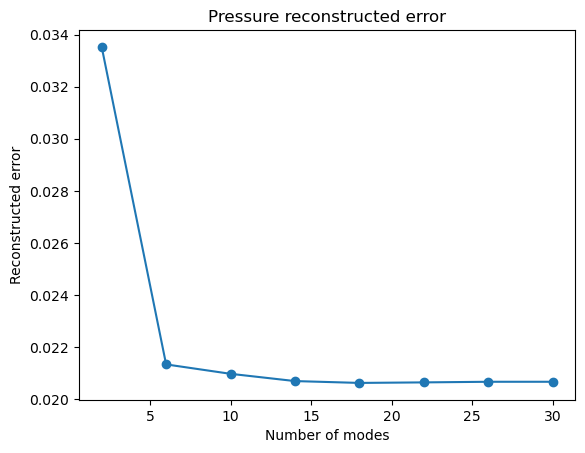

In [37]:
# print the error using 5 modes
p_error_list = np.array(p_error_list)
p_error_mean = np.mean(p_error_list, axis=1)

plt.plot(range(2, 32, 4), p_error_mean, marker='o')
plt.title('Pressure reconstructed error')
plt.xlabel('Number of modes')
plt.ylabel('Reconstructed error')
plt.show()

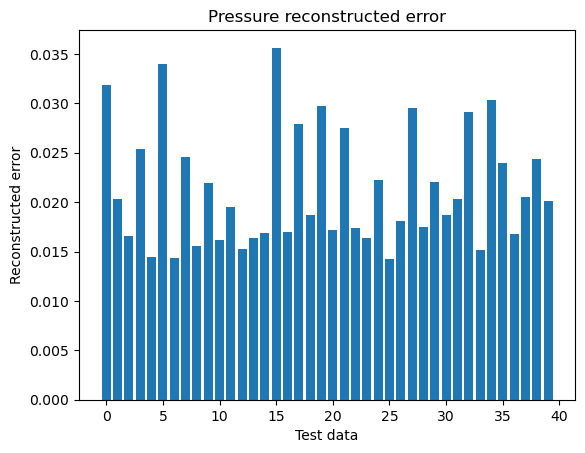

In [39]:
# plot the error for each test data using 6 modes
plt.bar([i for i in range(len(p_error_list[1]))], p_error_list[1])
plt.title('Pressure reconstructed error')
plt.xlabel('Test data')
plt.ylabel('Reconstructed error')
plt.show()

In [40]:
# Perform PODI on the velocity data
# Best kernel: gaussian, Best epsilon: 10.0

u_error_list = []

for i in range(2, 38, 5):
    u_POD, u_kernal, u_epsilon, u_scalar = POD_eval(train_velocity, train_design_parameters, epsilon=i)

    u_rom = PODI_rom(u_POD, u_kernal, u_epsilon, train_design_parameters, train_velocity)

    test_design_parameters_scaled = u_scalar.transform(test_design_parameters)
    u_predict = u_rom.predict(test_design_parameters_scaled)

    # calculate the reconstrcuted error for each test data using mean squared error
    u_error_list.append(np.linalg.norm(test_velocity - u_predict.snapshots_matrix, axis=1) / np.linalg.norm(test_velocity, axis=1))

    # # plot the error
    # plt.bar([i for i in range(len(u_reconstructed_error))], u_reconstructed_error)
    # plt.title('Pressure reconstructed error')
    # plt.xlabel('Test data')
    # plt.ylabel('Reconstructed error')
    # plt.show()

Number of modes: 2
Number of modes: 7
Number of modes: 12
Number of modes: 17
Number of modes: 22
Number of modes: 27
Number of modes: 32
Number of modes: 37


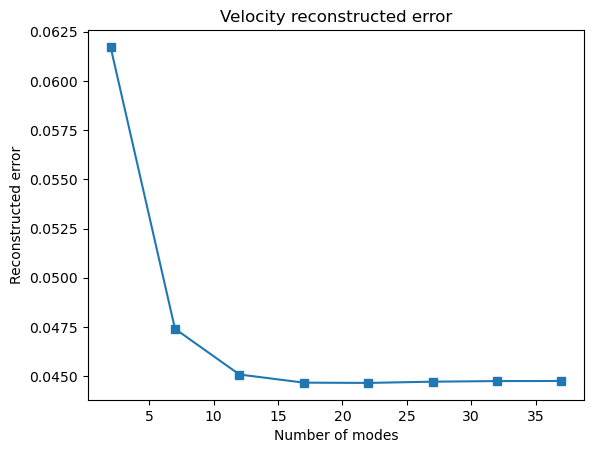

In [43]:
# print the error using different number of modes
u_error_list = np.array(u_error_list)
u_error_mean = np.mean(u_error_list, axis=1)

plt.plot(range(2, 38, 5), u_error_mean, marker='s')
plt.title('Velocity reconstructed error')
plt.xlabel('Number of modes')
plt.ylabel('Reconstructed error')
plt.show()

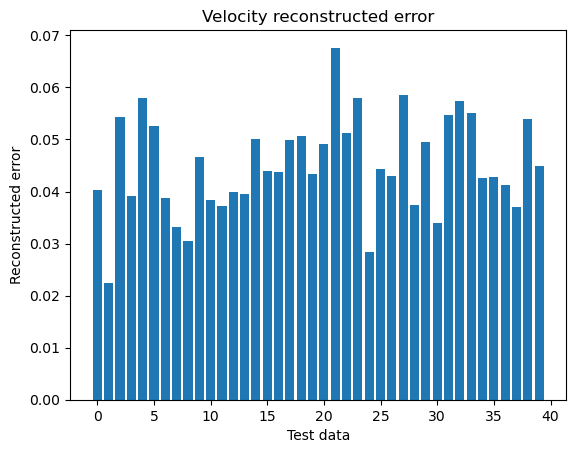

In [45]:
# plot the error of each case when using 7 modes
plt.bar([i for i in range(len(u_error_list[2]))], u_error_list[2])
plt.title('Velocity reconstructed error')
plt.xlabel('Test data')
plt.ylabel('Reconstructed error')
plt.show()

### 5. VTK visualization

In [54]:
selected_rank = 7

u_POD, u_kernal, u_epsilon, u_scalar = POD_eval(train_velocity, train_design_parameters, epsilon=selected_rank)

u_rom = PODI_rom(u_POD, u_kernal, u_epsilon, train_design_parameters, train_velocity)

test_design_parameters_scaled = u_scalar.transform(test_design_parameters)
u_predict = u_rom.predict(test_design_parameters_scaled)

Number of modes: 7


In [55]:
# Define a funtion to write the data into a VTK file
def vtk_writer(field_data, field_name, data_type,
               refVTM, save_path_name, points_data = None):
    # Add velocity data to each block within the MultiBlock dataset
    
    for block_i in range(refVTM.n_blocks):
        block = refVTM[block_i]
        if block is not None:
            if data_type == 'scalar':
                for data_i in range(len(field_name)):
                    block.cell_data[field_name[data_i]] = field_data[data_i]
            elif data_type == 'vector':
                for data_i in range(len(field_name)):
                    field = field_data[data_i].reshape(3, -1).T
                    block.cell_data[field_name[data_i]] = field 
            if points_data is not None:
                points = points_data.reshape(3, -1).T
                block.points = points

    # Save the modified VTM file
    output_vtm_file_path = f'{save_path_name}.vtm'
    refVTM.save(output_vtm_file_path)

In [56]:
refVTM = pv.MultiBlock('simulation_data/refCase/VTK/refCase_0.vtm')

In [44]:
# write the truth data, reconstructed data, and error into a VTK file
# Load the reference mesh VTM file
refVTM = pv.MultiBlock('simulation_data/refCase/VTK/refCase_0.vtm')
field_name = ['truth', 'reconstructed', 'error']
p_error_field = test_pressure - p_predict.snapshots_matrix

# loop all test data and write the data into VTK file
for i in range(len(test_pressure)):
    vtk_writer([test_pressure[i], p_predict.snapshots_matrix[i], p_error_field[i]], 
                field_name, 'scalar', refVTM, f'visualization_data/EZyRB_PODI_RBF/test_case_{i}_pressure', test_points[i])

In [57]:
# Write the velocity data into VTK file
field_name = ['truth', 'reconstructed', 'error']
u_error_field = test_velocity - u_predict.snapshots_matrix

# loop all test data and write the data into VTK file
for i in range(len(test_velocity)):
    vtk_writer([test_velocity[i], u_predict.snapshots_matrix[i], u_error_field[i]], 
                field_name, 'vector', refVTM, f'visualization_data/EZyRB_PODI_RBF/test_case_{i}_velocity', test_points[i])

In [32]:
# plot the pressure modes 
modes_name = [f'mode_{i}' for i in range(p_POD.modes.shape[1])]

vtk_writer(p_POD.modes.T, modes_name, 'scalar', refVTM, f'visualization_data/POD_modes/pressure_modes')

In [33]:
# plot the velocity modes
modes_name = [f'mode_{i}' for i in range(u_POD.modes.shape[1])]
vtk_writer(u_POD.modes.T, modes_name, 'vector', refVTM, f'visualization_data/POD_modes/velocity_modes')